In [2]:
import math
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.animation as animation 
%matplotlib notebook
import mpl_toolkits.mplot3d.axes3d as p3
from scipy.integrate import odeint

In [89]:
# define inertia
m = 1.33 # kg
l = 0.1 # m
I_xx = 1/12*m*(2*l**2) # kg m^2
I_yy = 1/12*m*(2*l**2) # kg m^2
I_zz = 1/12*m*(2*l**2) # kg m^2
I = np.array([[I_xx, 0, 0],[0, I_yy, 0],[0, 0 ,I_zz]])

# define external torque
tau = 0

# define initial state
# euler angles
phi = np.pi/4      # "roll" FEEL FREE TO CHANGE THIS VALUE
theta = np.pi/4       # "pitch" FEEL FREE TO CHANGE THIS VALUE
psi = np.pi/4      # "yaw" FEEL FREE TO CHANGE THIS VALUE
# rotation matrix 
A_x = np.array([[1, 0, 0],
               [0, np.cos(phi), -np.sin(phi)], 
               [0, np.sin(phi), np.cos(phi)]])
A_y = np.array([[np.cos(theta), 0, np.sin(theta)],
               [0, 1, 0], 
               [-np.sin(theta), 0, np.cos(theta)]])
A_z = np.array([[np.cos(psi), -np.sin(psi), 0],
               [np.sin(psi), np.cos(psi), 0], 
               [0, 0, 1]])
A = A_z @ A_y @ A_x
# euler axis angle
theta_a = np.arccos((A[0,0]+A[1,1]+A[2,2]-1)/2)
e_1 = (A[2,1]-A[1,2])/(2*np.sin(theta_a))
e_2 = (A[0,2]-A[2,0])/(2*np.sin(theta_a))
e_3 = (A[1,0]-A[0,1])/(2*np.sin(theta_a))
# quaternion
q_x0 = e_1*np.sin(theta_a/2)
q_y0 = e_2*np.sin(theta_a/2)
q_z0 = e_3*np.sin(theta_a/2)
q_w0 = np.cos(theta_a/2)
q_0 = np.array([q_x0, q_y0, q_z0, q_w0])

omega_x0 = 10*np.pi/180 # roll velocity
omega_y0 = 0 # pitch velocity
omega_z0 = 0 # yaw velocity
omega_0 = np.array([omega_x0,omega_y0,omega_z0])

# q_0 = np.array([1, 0, 0, 0])
# initiate state with quaternion
s_0 = np.concatenate((q_0,omega_0), axis=0)

In [90]:
# ode for kinematics/dynamics using quaternion state
def q_model(s,t,I,tau):
    # break out state
    q = s_0[0:4]
    qmag = np.sqrt(q.dot(q))
    q1 = s_0[0]/qmag
    q2 = s_0[1]/qmag
    q3 = s_0[2]/qmag
    q4 = s_0[3]/qmag
    w1 = s_0[4]
    w2 = s_0[5]
    w3 = s_0[6]
    w = np.array([[w1],[w2],[w3]])
    
    # define derivative
    print(q)
    qmat = np.array([[q4, -q3, q2],[q3, q4, -q1],[-q2, q1, q4],[-q1, -q2, -q3]])
    print(qmat)
    qdot = 1/2*qmat@w
    
    wcross = np.array([[0,-w3,w2],[w3,0,-w1],[-w2,w1,0]])
    wdot = -np.linalg.inv(I)@(wcross@(I@w))

    # return state derivative
    sdot = np.concatenate((qdot[:,0],wdot[:,0]), axis=0)
    
    return sdot

In [91]:
# time points
t = np.linspace(0, 100, 1001)

# integrate
y = odeint(q_model, s_0, t, args=(I,tau))

[0.19134172 0.46193977 0.19134172 0.8446232 ]
[[ 0.8446232  -0.19134172  0.46193977]
 [ 0.19134172  0.8446232  -0.19134172]
 [-0.46193977  0.19134172  0.8446232 ]
 [-0.19134172 -0.46193977 -0.19134172]]
[0.19134172 0.46193977 0.19134172 0.8446232 ]
[[ 0.8446232  -0.19134172  0.46193977]
 [ 0.19134172  0.8446232  -0.19134172]
 [-0.46193977  0.19134172  0.8446232 ]
 [-0.19134172 -0.46193977 -0.19134172]]
[0.19134172 0.46193977 0.19134172 0.8446232 ]
[[ 0.8446232  -0.19134172  0.46193977]
 [ 0.19134172  0.8446232  -0.19134172]
 [-0.46193977  0.19134172  0.8446232 ]
 [-0.19134172 -0.46193977 -0.19134172]]
[0.19134172 0.46193977 0.19134172 0.8446232 ]
[[ 0.8446232  -0.19134172  0.46193977]
 [ 0.19134172  0.8446232  -0.19134172]
 [-0.46193977  0.19134172  0.8446232 ]
 [-0.19134172 -0.46193977 -0.19134172]]
[0.19134172 0.46193977 0.19134172 0.8446232 ]
[[ 0.8446232  -0.19134172  0.46193977]
 [ 0.19134172  0.8446232  -0.19134172]
 [-0.46193977  0.19134172  0.8446232 ]
 [-0.19134172 -0.46193977

1.0
1.0000380764525652
1.0001522971126882
1.0003426358975809
1.0006090493690065
1.0009514767827994
1.001369840158011
1.0018640443654954
1.0024339772357018
1.0030795096853893
1.0038004958629319
1.0045967733118337
1.0054681631520321
1.0064144702785172
1.0074354835767643
1.0085309761544274
1.0097007055887153
1.0109444141888266
1.012261829272804
1.0136526634581249
1.0151166149653303
1.0166533679339702
1.0182625927501177
1.0199439463846982
1.0216970727418604
1.0235216030166014
1.0254171560608656
1.0273833387573148
1.029419746399978
1.0315259630809859
1.0337015620826009
1.0359461062737563
1.038259148510331
1.0406402320383983
1.0430888908996965
1.0456046503385874
1.0481870272097884
1.0508355303861785
1.053549661166004
1.0563289136788294
1.0591727752896047
1.0620807270002428
1.065052243848131
1.0680867953010214
1.07118384564778
1.0743428543844937
1.0775632765954717
1.0808445633287007
1.0841861619653446
1.0875875165829054
1.0910480683117003
1.0945672556843218
1.0981445149777942
1.10177928054815

<IPython.core.display.Javascript object>


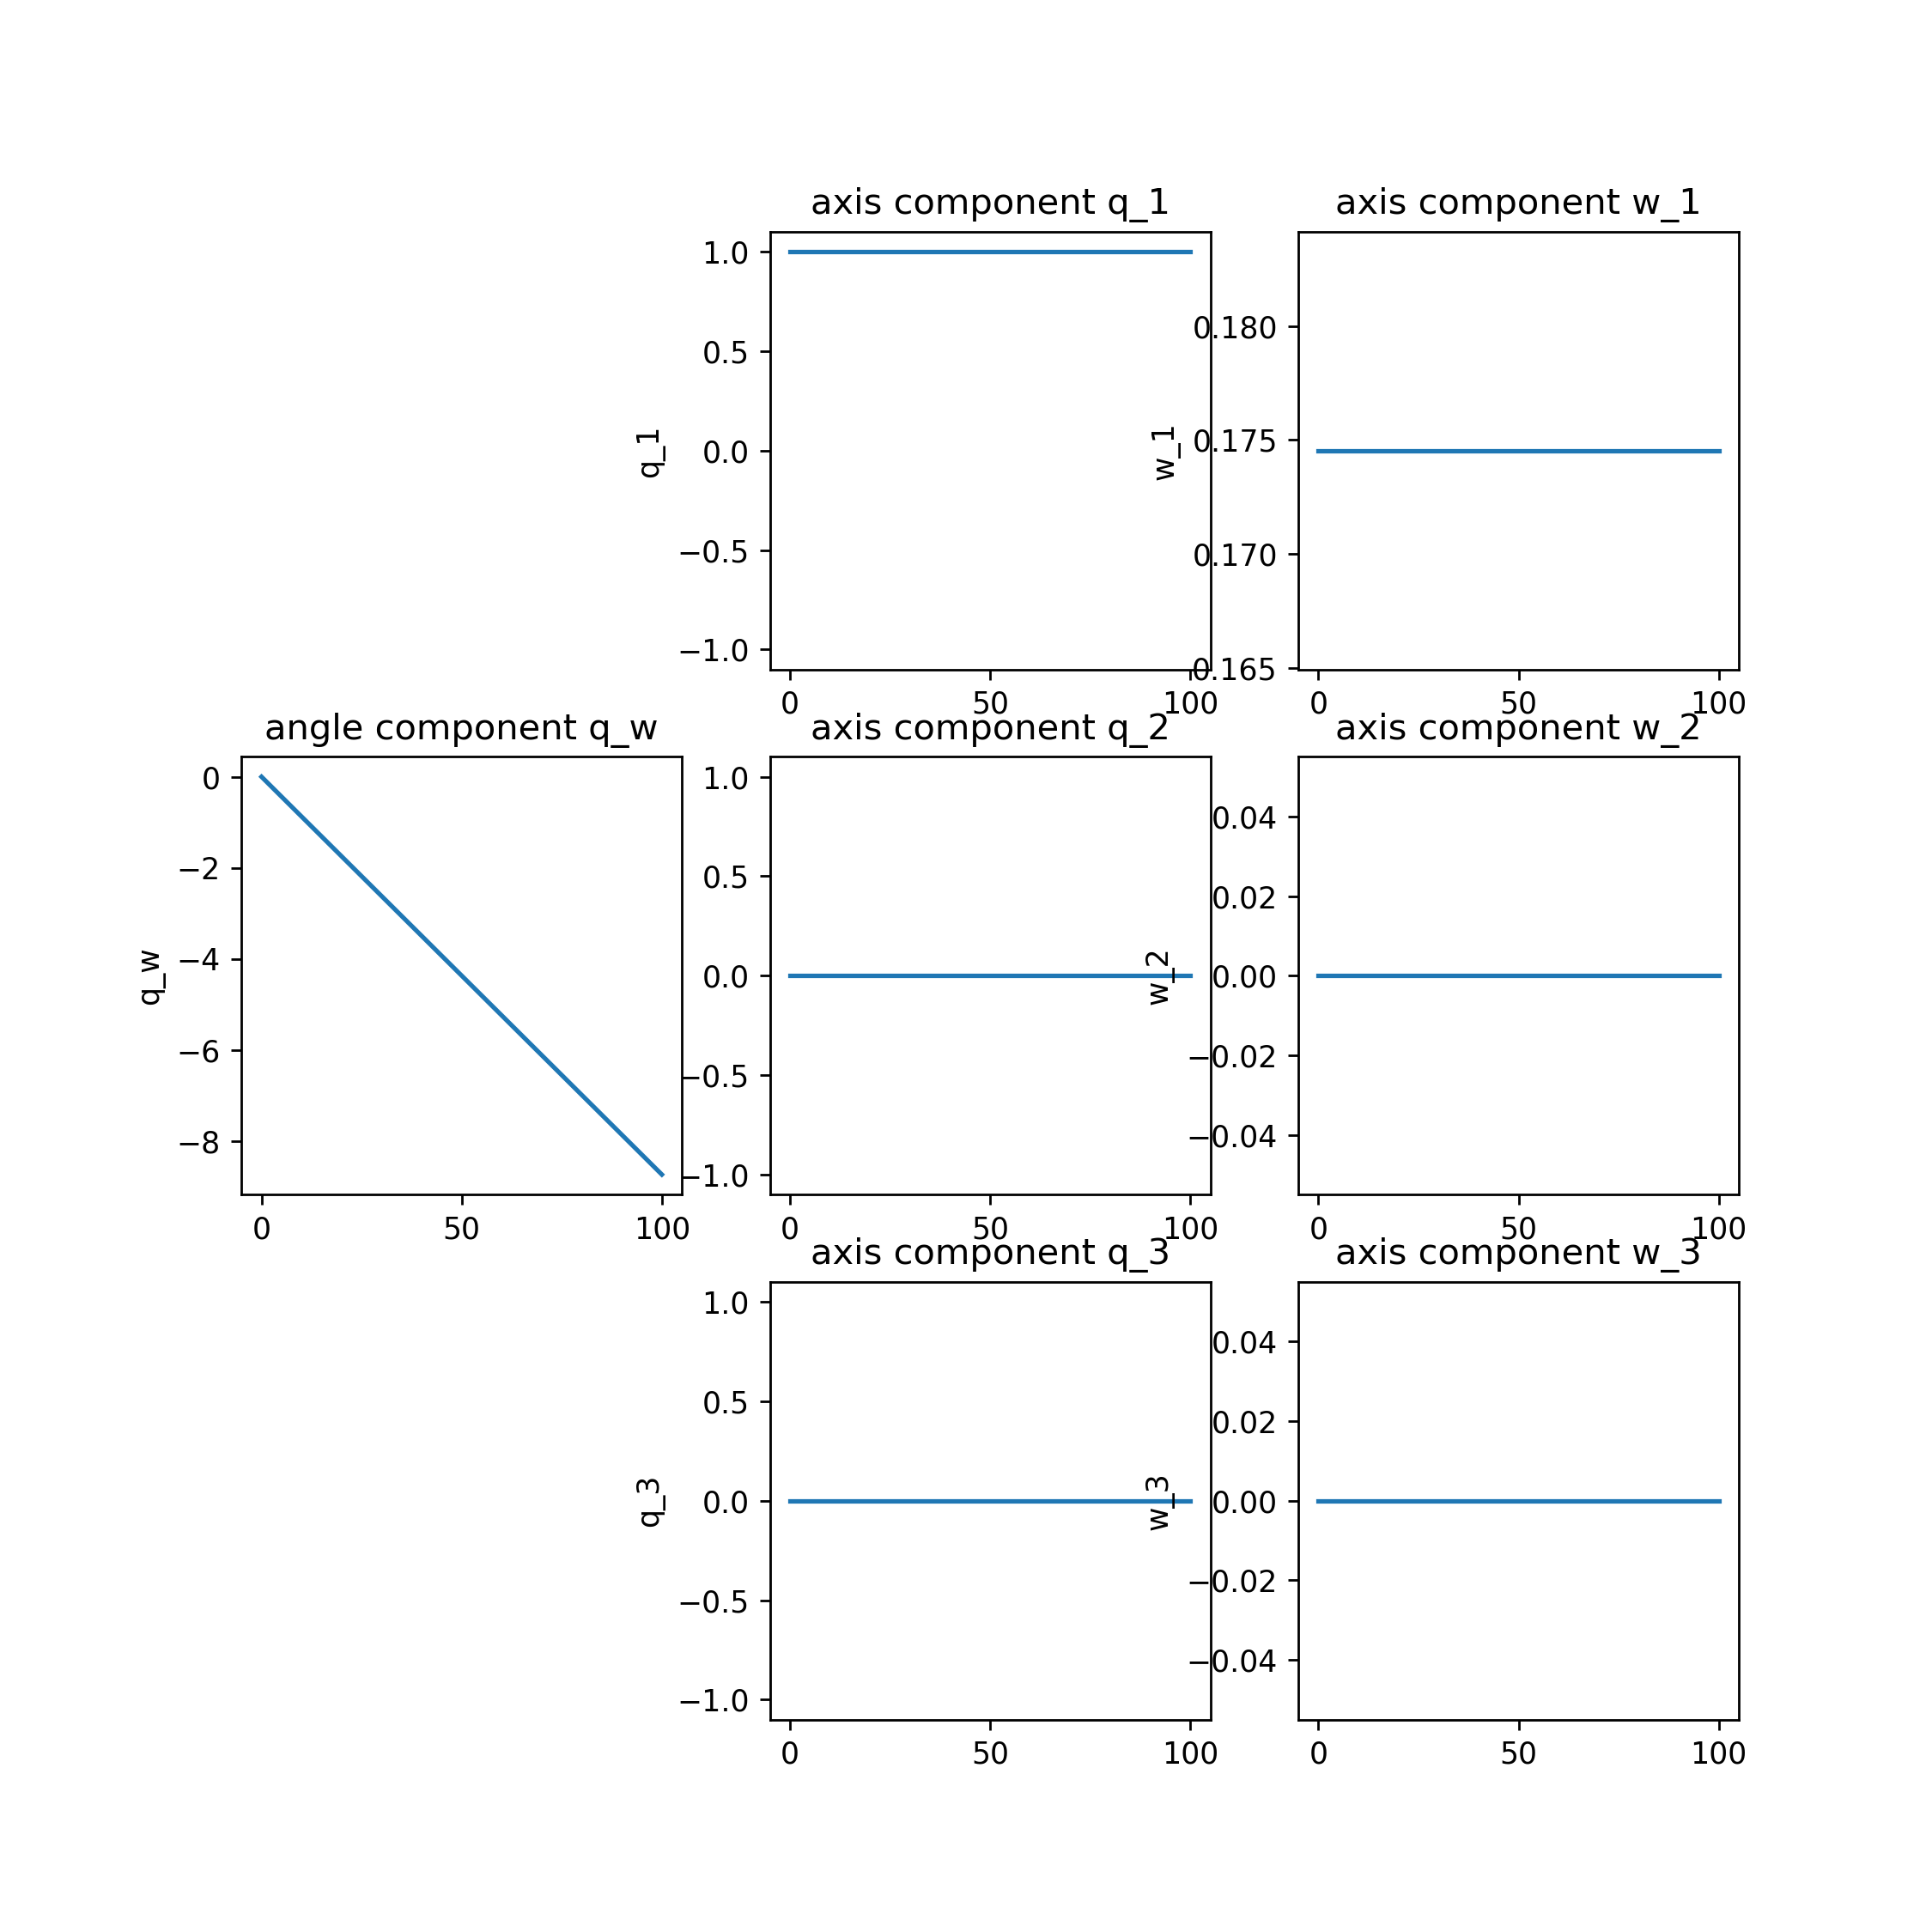

Text(0.5, 1.0, 'axis component w_3')

In [86]:
q_t = y[:,0:4]
for i in range(len(q_t)):
    q = q_t[i,:]
    qmag = np.sqrt(q.dot(q))
#     q_t[i,:] = q/qmag
    print(qmag)
w_t = y[:,4:7]

fig = plt.figure(figsize=(9,9))
plt.subplot(332)
plt.plot(t,q_t[:,0])
plt.ylabel('q_1')
plt.title('axis component q_1')
plt.ylim(-1.1,1.1)
plt.subplot(335)
plt.plot(t,q_t[:,1])
plt.ylabel('q_2')
plt.title('axis component q_2')
plt.ylim(-1.1,1.1)
plt.subplot(338)
plt.plot(t,q_t[:,2])
plt.ylabel('q_3')
plt.title('axis component q_3')
plt.ylim(-1.1,1.1)
plt.subplot(334)
plt.plot(t,q_t[:,3])
plt.ylabel('q_w')
plt.title('angle component q_w')
plt.subplot(333)
plt.plot(t,w_t[:,0])
plt.ylabel('w_1')
plt.title('axis component w_1')
plt.subplot(336)
plt.plot(t,w_t[:,1])
plt.ylabel('w_2')
plt.title('axis component w_2')
plt.subplot(339)
plt.plot(t,w_t[:,2])
plt.ylabel('w_3')
plt.title('axis component w_3')


In [20]:
# initiate state with rotation matrix
r_0 = np.concatenate((A[0,:], A[1,:], A[2,:]))
s_0 = np.concatenate((r_0,omega_0), axis=0)

In [30]:
# ode for kinematics/dynamics using rotation matrix state
def R_model(s,t,I,tau):
    # break out state
    r = s_0[0:9]
    R = np.array([r[0:3],r[3:6],r[6:9]])
    w1 = s_0[9]
    w2 = s_0[10]
    w3 = s_0[11]
    w = np.array([[w1],[w2],[w3]])
    
    # define derivative
    wcross = np.array([[0,w3,-w2],[-w3,0,w1],[w2,-w1,0]])
    
    Rdot = R@wcross
    rdot = np.concatenate((Rdot[0,:], Rdot[1,:], Rdot[2,:]))
    
    wdot = -np.linalg.inv(I)@(wcross@I@w)
    
    # return state derivative
    sdot = np.concatenate((rdot,wdot[:,0]), axis=0)
    
    return sdot

<IPython.core.display.Javascript object>


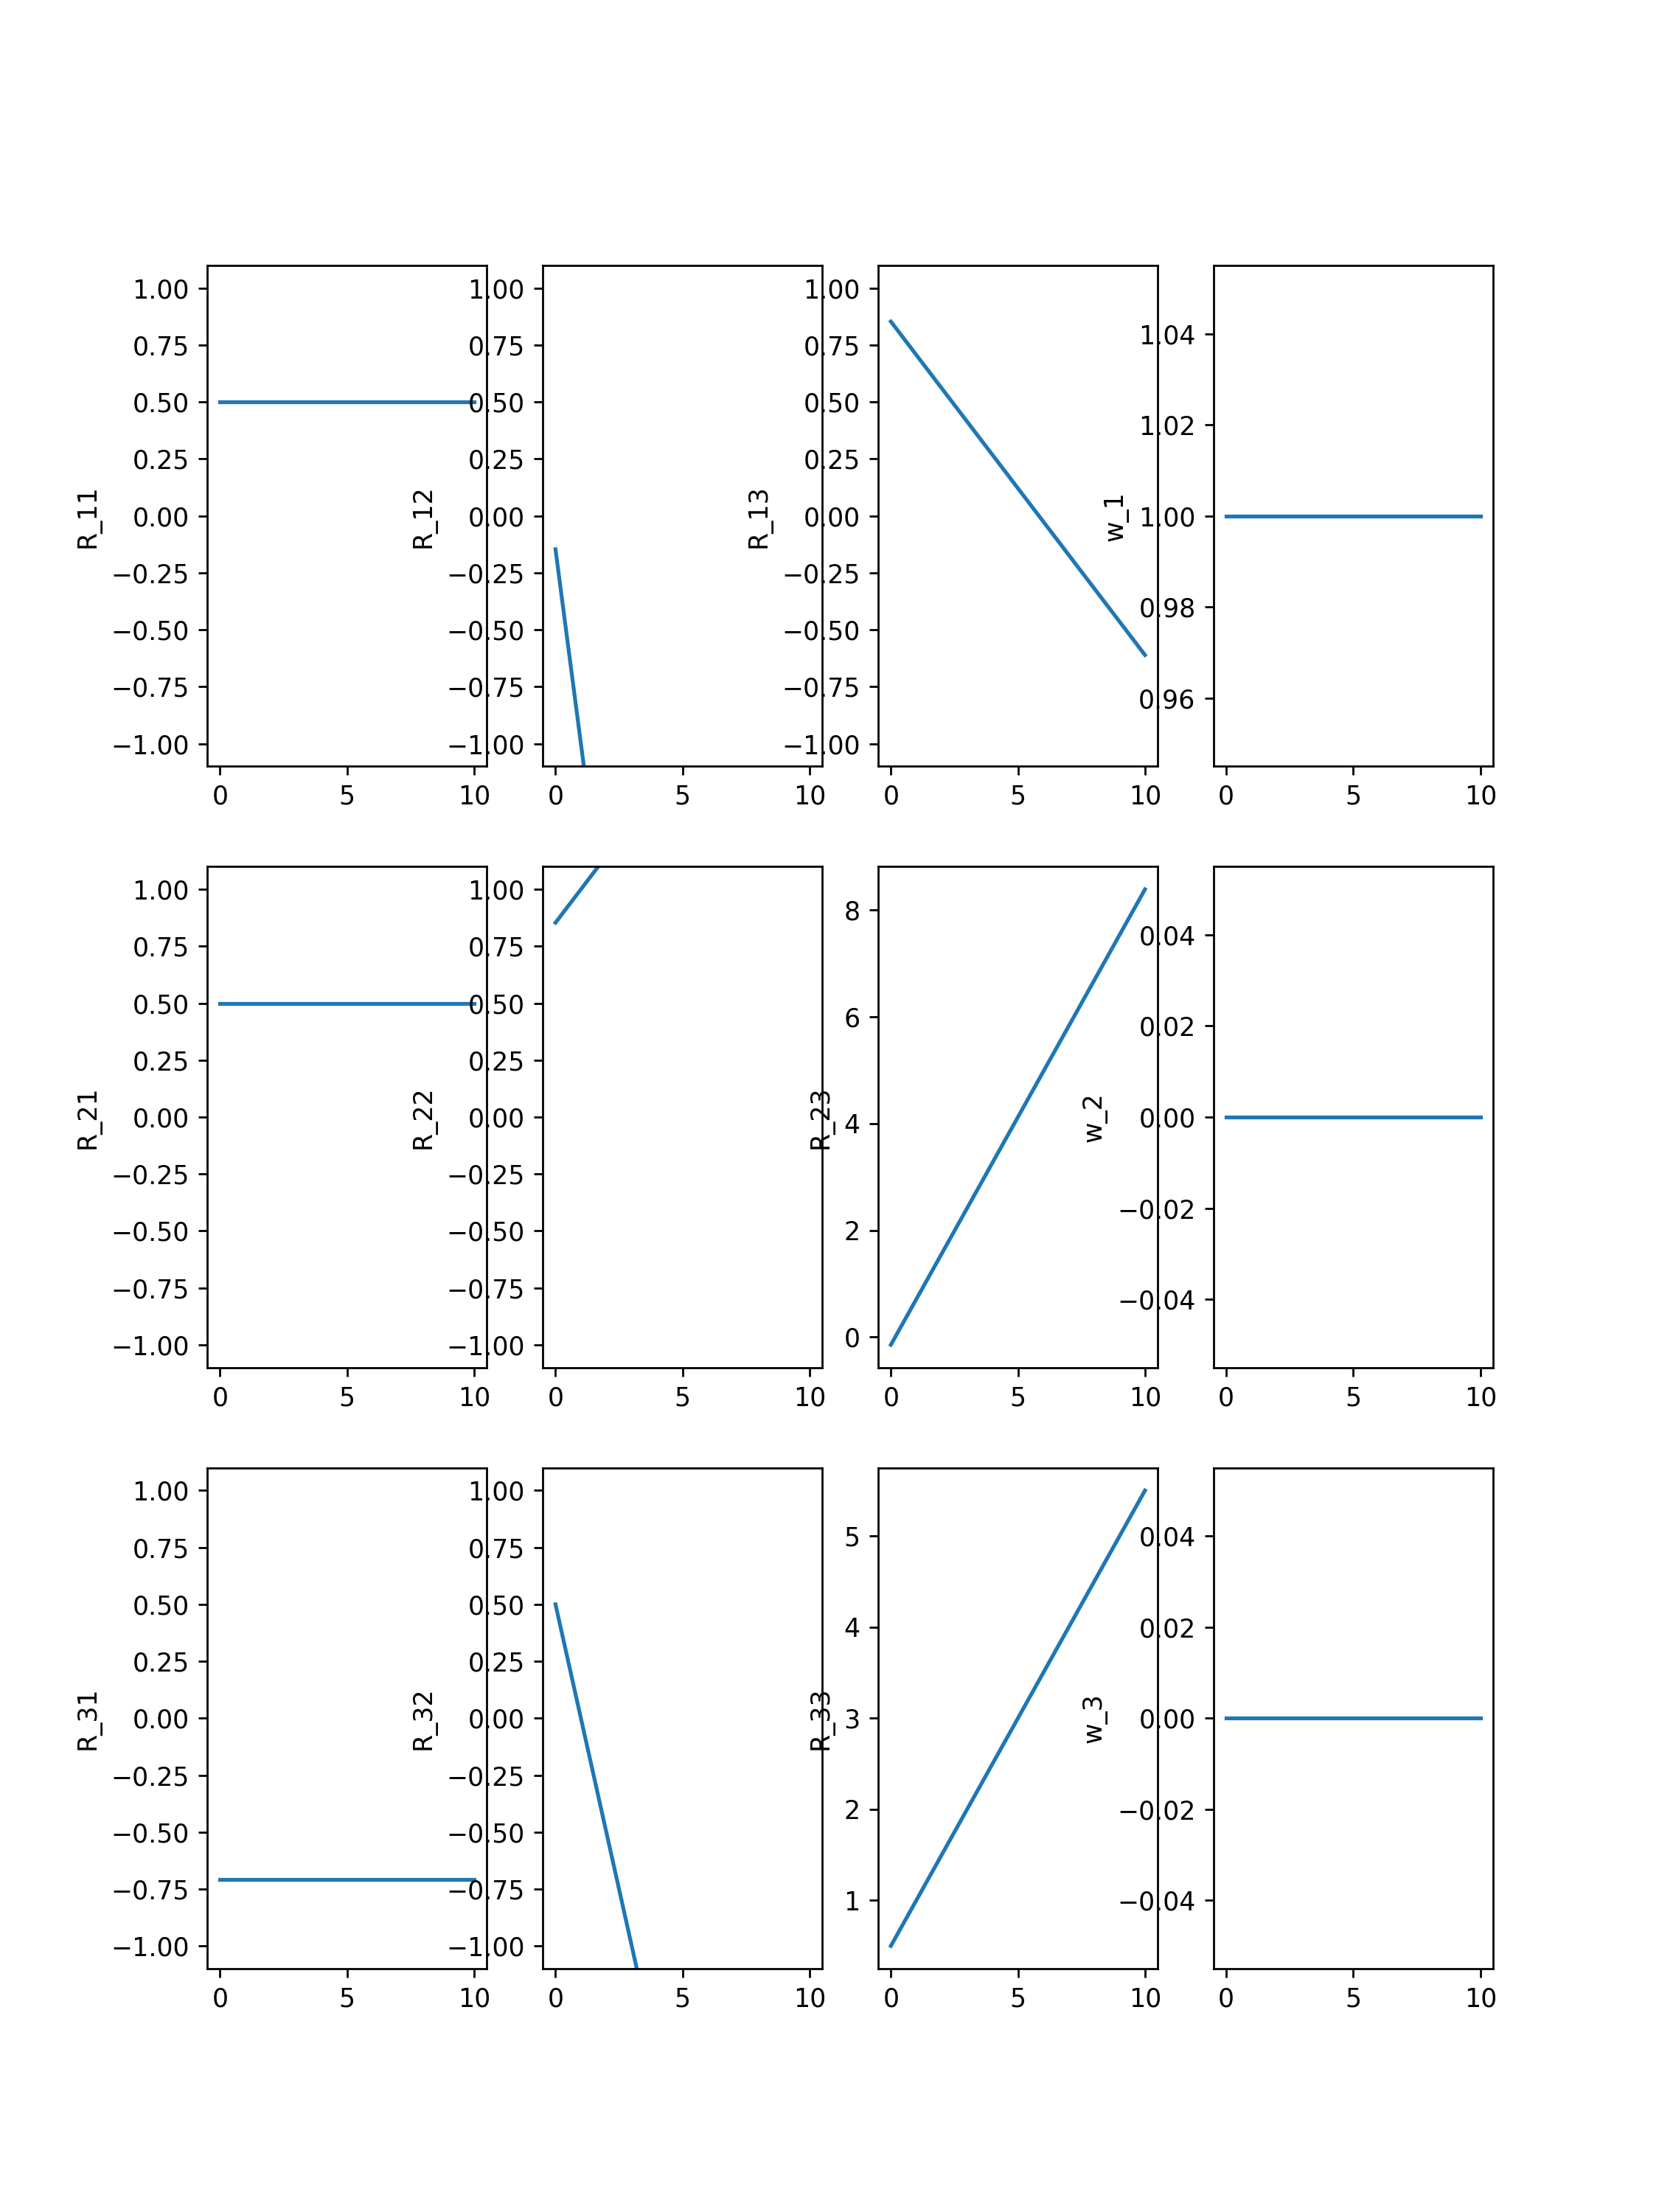

Text(0, 0.5, 'w_3')

In [35]:
# time points
t = np.linspace(0, 10, 101)

# integrate
y = odeint(R_model, s_0, t, args=(I,tau))
R_t = y[:,0:9]
w_t = y[:,9::]

fig = plt.figure(figsize=(9,12))
plt.subplot(3,4,1)
plt.plot(t,R_t[:,0])
plt.ylabel('R_11')
plt.ylim(-1.1,1.1)
plt.subplot(342)
plt.plot(t,R_t[:,1])
plt.ylabel('R_12')
plt.ylim(-1.1,1.1)
plt.subplot(343)
plt.plot(t,R_t[:,2])
plt.ylabel('R_13')
plt.ylim(-1.1,1.1)
plt.subplot(344)
plt.plot(t,w_t[:,0])
plt.ylabel('w_1')
plt.subplot(345)
plt.plot(t,R_t[:,3])
plt.ylabel('R_21')
plt.ylim(-1.1,1.1)
plt.subplot(346)
plt.plot(t,R_t[:,4])
plt.ylabel('R_22')
plt.ylim(-1.1,1.1)
plt.subplot(347)
plt.plot(t,R_t[:,5])
plt.ylabel('R_23')
plt.subplot(348)
plt.plot(t,w_t[:,1])
plt.ylabel('w_2')
plt.subplot(349)
plt.plot(t,R_t[:,6])
plt.ylabel('R_31')
plt.ylim(-1.1,1.1)
plt.subplot(3,4,10)
plt.plot(t,R_t[:,7])
plt.ylabel('R_32')
plt.ylim(-1.1,1.1)
plt.subplot(3,4,11)
plt.plot(t,R_t[:,8])
plt.ylabel('R_33')
plt.subplot(3,4,12)
plt.plot(t,w_t[:,2])
plt.ylabel('w_3')
